In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import metrics

In [9]:
from sklearn import svm
from sklearn import linear_model
from sklearn import ensemble
import xgboost as xgb

In [10]:
data = pd.read_csv('cars.csv')

In [11]:
data.head()

,Unnamed: 0,speed,dist
0,1,4,2
1,2,4,10
2,3,7,4
3,4,7,22
4,5,8,16


In [13]:
data.count()

Unnamed: 0    50
speed         50
dist          50
dtype: int64

In [14]:
data.describe()

,Unnamed: 0,speed,dist
count,50.00000,50.000000,50.000000
mean,25.50000,15.400000,42.980000
std,14.57738,5.287644,25.769377
min,1.00000,4.000000,2.000000
25%,13.25000,12.000000,26.000000
50%,25.50000,15.000000,36.000000
75%,37.75000,19.000000,56.000000
max,50.00000,25.000000,120.000000


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  50 non-null     int64
 1   speed       50 non-null     int64
 2   dist        50 non-null     int64
dtypes: int64(3)
memory usage: 1.3 KB


In [16]:
data.isna().sum()

Unnamed: 0    0
speed         0
dist          0
dtype: int64

In [17]:
data.drop(columns=['Unnamed: 0'], inplace=True)

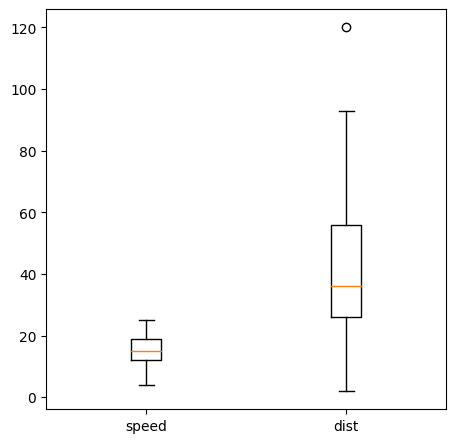

In [18]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data)
plt.xticks([1,2],data.columns)
plt.show()

In [19]:
outlier = np.argmax(data.loc[:,'dist'], axis = 0)

In [20]:
outlier

48

In [21]:
data.iloc[outlier,:]

speed     24
dist     120
Name: 48, dtype: int64

In [22]:
data_no_outlier = data.drop(index=[48])

In [23]:
data_no_outlier.shape

(49, 2)

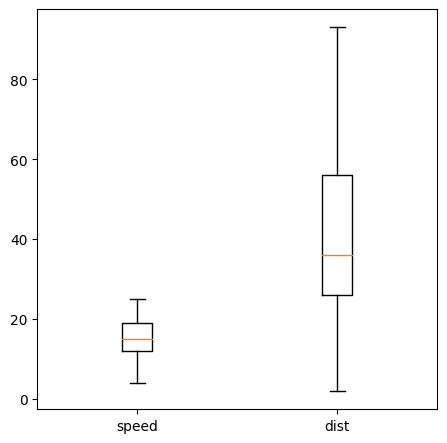

In [24]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(data_no_outlier)
plt.xticks([1,2],data.columns)
plt.show()

In [25]:
x=data.drop(columns=['dist'])
y=data['dist']

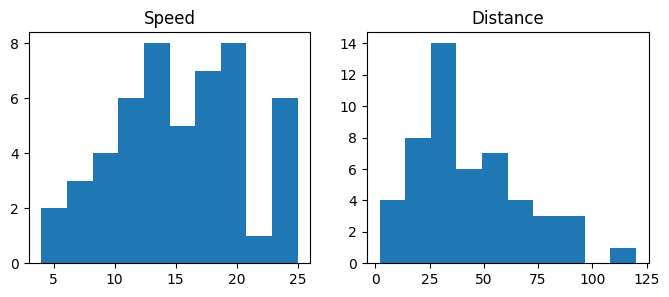

In [26]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.title('Speed')
plt.hist(x)
plt.subplot(1,2,2)
plt.title('Distance')
plt.hist(y)
plt.show()

In [27]:
feature_names = x.columns

In [28]:
x.head()


,speed
0,4
1,4
2,7
3,7
4,8


In [29]:
np.corrcoef(x['speed'].values, y.values.ravel())[0, 1]

0.8068949006892103

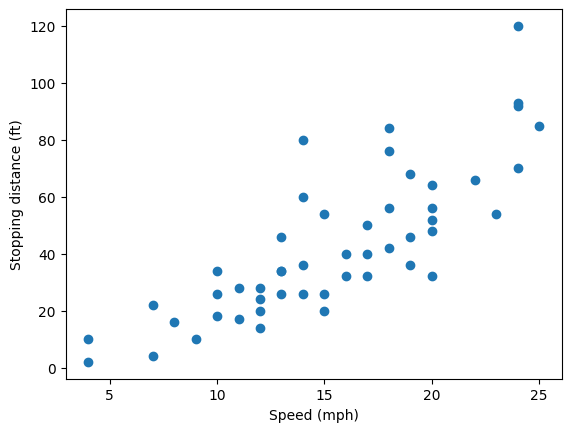

In [30]:
plt.plot(x.speed, y,'o')
plt.xlabel('Speed (mph)')
plt.ylabel('Stopping distance (ft)')
plt.show()

In [31]:
feature_names = x.columns

In [32]:
data_no_outlier = data.drop(index=[48])

In [33]:
data_no_outlier.reset_index(inplace=True, drop=True)

In [34]:
x=data_no_outlier.drop(columns=['dist'])
y=data_no_outlier['dist']

# Model selection and evaluation

In [35]:
results={}

In [36]:
def evaluate_model(base_model, k_folds = 5, params={}):
    cv = model_selection.KFold(n_splits=k_folds, shuffle=True)
    scores=[]
    best={}
    best['best_score']=-10000
    for train_ind, test_ind in cv.split(x,y):
        x_train=x.iloc[train_ind,:]
        y_train = y[train_ind]
        x_test = x.iloc[test_ind, :]
        y_test = y[test_ind]
        scaler = preprocessing.StandardScaler()
        scaler.fit(x_train)
        x_train  = scaler.transform(x_train)
        x_test = scaler.transform(x_test)
        if len(params) >0:
            model = model_selection.GridSearchCV(base_model,params, cv=5)
        else:
            model = base_model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        score = metrics.r2_score(y_test,y_pred)
        if(score > best['best_score']):
            best['best_score'] = score
            if len(params) >0:
                best['params'] = model.best_params_
        scores.append(score)
    best['scores']=scores
    return best

### SVM model

In [37]:
params = {'gamma':[10**i for i in range(-3,1)],'C':[10**i for i in range(1,4)],'kernel' :['linear','rbf']}
model = svm.SVR()

results['SVM'] = evaluate_model(model,params= params)

In [38]:
results['SVM']

{'best_score': 0.7963845615551056,
 'params': {'C': 1000, 'gamma': 0.001, 'kernel': 'linear'},
 'scores': [0.6198750722668576,
  0.7343355805977718,
  0.6441121558864787,
  0.7963845615551056,
  -0.22933608701676422]}

### Linear model

In [39]:
model = linear_model.LinearRegression()
results['Linear regression'] = evaluate_model(model)

In [40]:
results['Linear regression']

{'best_score': 0.8011359720569258,
 'scores': [0.8011359720569258,
  0.3588867903679299,
  0.3170640446523436,
  0.6788986304188787,
  0.6320431317357277]}

### Linear SVM

In [41]:
model = linear_model.LinearRegression()
results['Linear SVM'] = evaluate_model(model)

In [42]:
results['Linear SVM']

{'best_score': 0.7895807743741798,
 'scores': [0.6240888281509123,
  0.6856649759325851,
  0.6155618879861995,
  0.7895807743741798,
  -0.2335855916401226]}

### Bayesian Ridge

In [43]:
model = linear_model.BayesianRidge()
results['Bayesian Ridge'] = evaluate_model(model)

In [44]:
results['Bayesian Ridge']

{'best_score': 0.8489207240773949,
 'scores': [0.8489207240773949,
  0.23340591156932322,
  0.27743586991095426,
  0.7843935318824421,
  0.5318707413204338]}

### Random Forest

In [45]:
params = {'n_estimators' : [10*i for i in range(1,5)],  'max_depth' : [2,3,4]}
model = ensemble.RandomForestRegressor()

results['Random Forest'] = evaluate_model(model,params =params)

In [46]:
results['Random Forest']

{'best_score': 0.7301529747685975,
 'params': {'max_depth': 2, 'n_estimators': 20},
 'scores': [0.5557843764302761,
  0.7301529747685975,
  0.6032451868682527,
  0.4413055609757086,
  0.6537858068890336]}

### XGBoost

In [47]:
params = {'n_estimators' : [10*i for i in range(1,5)], 'max_depth' : [2,3,4]}
model = xgb.XGBRegressor()

results['XDBoost'] = evaluate_model(model,params= params)

In [48]:
results['XDBoost']

{'best_score': 0.6441574362191629,
 'params': {'max_depth': 2, 'n_estimators': 10},
 'scores': [-0.001738370856235294,
  0.4676300732225285,
  -0.2262924448093464,
  0.1313543003117662,
  0.6441574362191629]}

# Final models

In [49]:
final_model = {}

In [50]:
final_model['Linear Regression']  = linear_model.LinearRegression()
final_model['Linear Regression'].fit(x,y)

LinearRegression()

In [51]:
final_model['Linear SVM']  = svm.LinearSVR()
final_model['Linear SVM'].fit(x,y)

LinearSVR()

In [52]:
params = results['SVM']['params']
gamma = params['gamma']
C = params['C']
final_model['SVM'] = svm.SVR(C=C,gamma=gamma)
final_model['SVM'].fit(x,y)

SVR(C=1000, gamma=0.001)

In [53]:
final_model['Bayesian Ridge']  = linear_model.BayesianRidge()
final_model['Bayesian Ridge'].fit(x,y)

BayesianRidge()

In [60]:
final_model['Bayesian Ridge'].coef_

array([3.59825993])

In [54]:

params = results['Random Forest']['params']
n_estimators = params['n_estimators']
max_depth = params['max_depth']
final_model['Random Forest']  =ensemble.RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth)
final_model['Random Forest'].fit(x,y)

RandomForestRegressor(max_depth=2, n_estimators=20)

In [55]:
params = results['XDBoost']['params']
n_estimators = params['n_estimators']
max_depth = params['max_depth']
final_model['XGBoost']  = xgb.XGBRegressor(n_estimators = n_estimators, max_depth = max_depth)
final_model['XGBoost'].fit(x,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

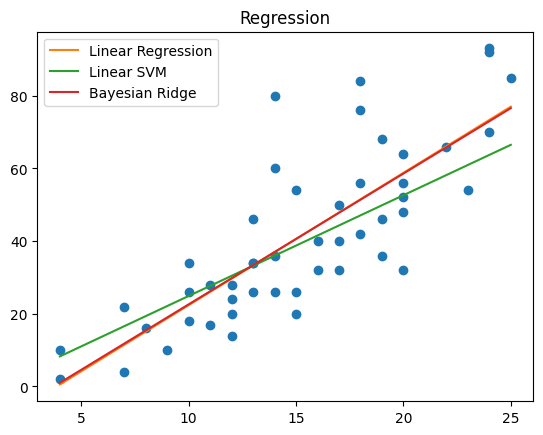

In [58]:
plt.title('Regression')
plt.plot(x, y,'o')
plt.plot(x, final_model['Linear Regression'].intercept_+final_model['Linear Regression'].coef_[0]*x, label='Linear Regression')
plt.plot(x, final_model['Linear SVM'].intercept_+final_model['Linear SVM'].coef_[0]*x,label = 'Linear SVM')
plt.plot(x, final_model['Bayesian Ridge'].intercept_+final_model['Bayesian Ridge'].coef_[0]*x,label = 'Bayesian Ridge')

plt.legend(loc='best')
plt.show()

In [57]:
import csv
with open('results.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in results.items():
       writer.writerow([key, value])
from google.colab import files
files.download("results.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>